In [54]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

In [62]:
import rasterio
import numpy as np
import classifier_utilities as cu
import keras
from keras.optimizers import SGD
import os
import resnet as rs

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [6]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))


In [38]:
train_pixels = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets, train_count=500000, 
                                            label_dataset=label_dataset, merge=False)

100%|██████████| 5/5 [08:03<00:00, 94.99s/it]


In [39]:
train_valratio = 0.9
val_testratio = 0.7
train_px = train_pixels[:int(len(train_pixels)*train_valratio)]
val_pixels = train_pixels[int(len(train_pixels)*train_valratio):]
val_px = val_pixels[:int(len(val_pixels)*val_testratio)]
test_px = val_pixels[int(len(val_pixels)*val_testratio):]

In [40]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

359252
27941
11976


In [20]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands, img_rows, img_cols)
print(input_shape)

(10, 64, 64)


In [47]:
model = rs.ResnetBuilder.build_resnet_101(input_shape,num_classes)

In [48]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, train_px, batch_size, merge=False), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size, merge=False),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/200
14370/14370 [==============================] - 6174s 430ms/step - loss: 12.7084 - acc: 0.2706 - val_loss: 12.4563 - val_acc: 0.3337
Epoch 2/200
14370/14370 [==============================] - 6099s 424ms/step - loss: 12.3713 - acc: 0.3452 - val_loss: 12.2756 - val_acc: 0.3617
Epoch 3/200
14370/14370 [==============================] - 5938s 413ms/step - loss: 12.1953 - acc: 0.3841 - val_loss: 12.1618 - val_acc: 0.3794
Epoch 4/200
14370/14370 [==============================] - 5862s 408ms/step - loss: 12.0528 - acc: 0.4159 - val_loss: 12.0775 - val_acc: 0.3893
Epoch 5/200
14370/14370 [==============================] - 5862s 408ms/step - loss: 11.9212 - acc: 0.4439 - val_loss: 11.9952 - val_acc: 0.3984
Epoch 6/200
14370/14370 [==============================] - 5863s 408ms/step - loss: 11.7913 - acc: 0.4742 - val_loss: 11.9369 - val_acc: 0.4006
Epoch 7/200
14370/14370 [==============================] - 5862s 408ms/step - loss: 11.6593 - acc: 0.5049 - val_loss: 11.8724 - val_acc:

KeyboardInterrupt: 

In [57]:
MERGE = True

479/479 [==============================] - 41s 85ms/step


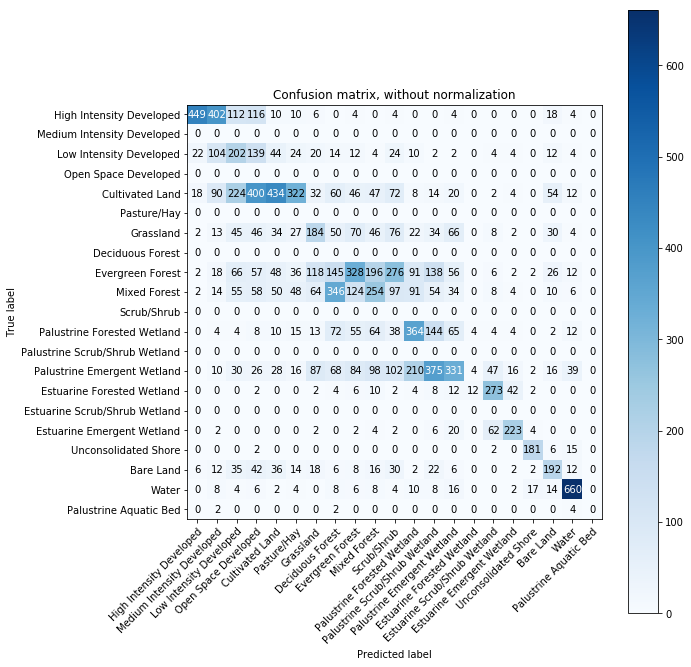

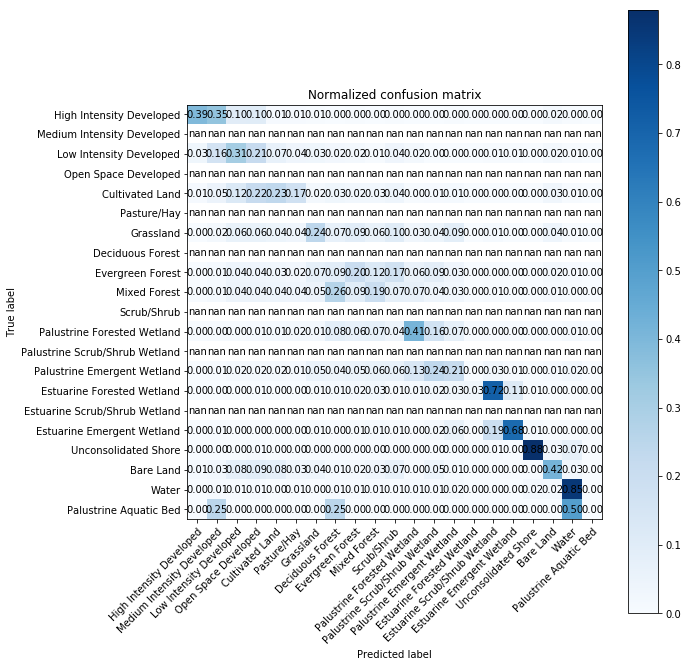

In [63]:
predictions = model.predict_generator(generator=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, test_px, batch_size, merge=MERGE), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

eval_generator = cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, tile_side, tile_side, test_px, batch_size=1, merge=MERGE)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [60]:
print(label_index.shape)

(11975,)
